<a href="https://colab.research.google.com/github/Joylan/ANN-Models/blob/main/analise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Etapas:
* Pre Processamento da base de dados
* Comparação de estruturas (camadas e número de neurônios)
* Comparação de inputs (todos vs dimensionality reduction)
* Comparação de horizontes: 1, 30 e 60 minutos.
* **FAZER COLOCAR TABELA DE COMPARAÇÕES**


* Distinto conjunto de Dados de entrada (reduzir dimensionalidade).
* Definir quais conjunto de variáveis/inputs (F1 e F2) usar
    * F1 Todos as variáveis meteorológicas + GHI 
    * F2 Features selection + GHI
* Treinar e avaliar os conjuntos de modelos
* Realizar as análises comparativas 
    * M1F1 e M1F2
    * M1F1 e M1F2
    * M2F1 e M2F2
* Elaboração de um modelo de predição
* Análise experimental.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importações

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

from sklearn.metrics import r2_score

import os
import time
from glob import glob

from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.offline as py


# Funções Auxiliares

Colocar aqui as funções que são auxiliares ao programa

In [ ]:
#Com GHI
def split_sequences_ghi(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 

#SEM GHI
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot) )

# Pre Processamento

FEITO: Criar uma função que carregue a base de dados do pedro, e retorne os 

dados preparados para entrar na rede neural.
Esta função tem como parametros de entrada:
1. Caminho até os dados meterologicos.
2. Caminho até os dados ghi.
3. As colunas que serão dropadas caso houver.
4. O horizonte dos dados

In [ ]:
def get_data(weatherPath: str, 
             irradiancePath: str,
             timeStamp: int,
             drops: list = None) -> pd.DataFrame:
    """Função carrega os dados do pedro

    Args:
        weatherPath (str): Caminho até os dados meterologicos
        irradiancePath (str): Caminho até os dados de irradiação
        timeStamp (int): O intervalo das medições
        drops (list, optional): Colunas a serem retiradas dos dados. Defaults to None.

    Returns:
        pd.DataFrame: DataFrame com os dados do pedro
    """
    if timeStamp == 60:
      if drops is None:
      
        dataWeather = pd.read_csv(weatherPath, index_col = 0, parse_dates = True)
        dataWeather["month"] = dataWeather.index.month
        dataWeather["day"] = dataWeather.index.day
        dataWeather["hour"] = dataWeather.index.hour
        

        dataIrradiance = pd.read_csv(irradiancePath, index_col = 0, usecols=[0,1],
                                    parse_dates = True)
        
        data = pd.concat([dataWeather,dataIrradiance], axis = 1)
        data.dropna(inplace=True)
        data = data[data.index.minute % timeStamp == 0]

        return data

      elif type(drops) is list:
        try:
          dataWeather = pd.read_csv(weatherPath, index_col = 0, parse_dates = True)
          dataWeather["month"] = dataWeather.index.month
          dataWeather["day"] = dataWeather.index.day
          dataWeather["hour"] = dataWeather.index.hour
          
          dataWeather.drop(drops,axis=1,inplace=True)

          dataIrradiance = pd.read_csv(irradiancePath, index_col = 0, usecols=[0,1],
                                      parse_dates = True)
          
          data = pd.concat([dataWeather,dataIrradiance], axis = 1)
          data.dropna(inplace=True)
          data = data[data.index.minute % timeStamp == 0]

        

          return data

        except KeyError:
          print("[INFO] Colunas selecionadas para remoção, não existem nos dados")
          print("[INFO] Nenhuma coluna foi removida")

          dataWeather = pd.read_csv(weatherPath, index_col = 0, parse_dates = True)
          dataWeather["month"] = dataWeather.index.month
          dataWeather["day"] = dataWeather.index.day
          dataWeather["hour"] = dataWeather.index.hour
          

          dataIrradiance = pd.read_csv(irradiancePath, index_col = 0, usecols=[0,1],
                                      parse_dates = True)
          
          data = pd.concat([dataWeather,dataIrradiance], axis = 1)
          data.dropna(inplace=True)
          data = data[data.index.minute % timeStamp == 0]

          return data

      else:
        raise TypeError("Argumento drops precisa ser None ou List")
    #não 60
    else:

      if drops is None:
        
        dataWeather = pd.read_csv(weatherPath, index_col = 0, parse_dates = True)
        dataWeather["month"] = dataWeather.index.month
        dataWeather["day"] = dataWeather.index.day
        dataWeather["hour"] = dataWeather.index.hour
        dataWeather["minute"] = dataWeather.index.minute

        dataIrradiance = pd.read_csv(irradiancePath, index_col = 0, usecols=[0,1],
                                    parse_dates = True)
        
        data = pd.concat([dataWeather,dataIrradiance], axis = 1)
        data.dropna(inplace=True)
        data = data[data.index.minute % timeStamp == 0]

        return data

      elif type(drops) is list:
        try:
          dataWeather = pd.read_csv(weatherPath, index_col = 0, parse_dates = True)
          dataWeather["month"] = dataWeather.index.month
          dataWeather["day"] = dataWeather.index.day
          dataWeather["hour"] = dataWeather.index.hour
          dataWeather["minute"] = dataWeather.index.minute
          dataWeather.drop(drops,axis=1,inplace=True)

          dataIrradiance = pd.read_csv(irradiancePath, index_col = 0, usecols=[0,1],
                                      parse_dates = True)
          
          data = pd.concat([dataWeather,dataIrradiance], axis = 1)
          data.dropna(inplace=True)
          data = data[data.index.minute % timeStamp == 0]

        

          return data

        except KeyError:
          print("[INFO] Colunas selecionadas para remoção, não existem nos dados")
          print("[INFO] Nenhuma coluna foi removida")

          dataWeather = pd.read_csv(weatherPath, index_col = 0, parse_dates = True)
          dataWeather["month"] = dataWeather.index.month
          dataWeather["day"] = dataWeather.index.day
          dataWeather["hour"] = dataWeather.index.hour
          dataWeather["minute"] = dataWeather.index.minute

          dataIrradiance = pd.read_csv(irradiancePath, index_col = 0, usecols=[0,1],
                                      parse_dates = True)
          
          data = pd.concat([dataWeather,dataIrradiance], axis = 1)
          data.dropna(inplace=True)
          data = data[data.index.minute % timeStamp == 0]

          return data

      else:
        raise TypeError("Argumento drops precisa ser None ou List")

# Modelo

FEITO: Função que cria os modelos de forma dinamica.
* Argumentos:
  1. Numero de entradas
  2. Numero de saidas
  3. Numero de camadas = lista com os numeros de neuronios em cada cama.
  4. dropout: Porcentagem de dropout
  5. batchNorm: Vai colocar batchnormalization? 
  6. função ativação: Vai mudar a função ativação?

* Retorno
  1. Retorna uma Sequencial(tf.keras.models.Sequentail)

In [ ]:
def get_model(n_in: int, 
              n_out: int,
              nLayers: list,
              dropout: float=0.15,
              batchNorm: bool=False,
              activ: str = "relu"
              ) -> tf.keras.models.Sequential :
    """[summary]

    Args:
        n_in (int): [description]
        n_out (int): [description]
        nLayers (list): [description]
        dropout (float, optional): [description]. Defaults to 0.15.
        batchNorm (bool, optional): [description]. Defaults to False.
        activ (str, optional): [description]. Defaults to "relu".

    Returns:
        tf.keras.models.Sequential: [description]
    """
    #Cria o Sequential
    model = Sequential()
    #Define uma semente randomica, para que cada inicialização de peso seja igual
    #em todas as redes
    seed = 2459

    if batchNorm:
    # Se o batchNorm for True, o modelo tera em cada camada uma camada de 
    # normalização dos batch (https://keras.io/api/layers/normalization_layers/batch_normalization/)

      for layer in nLayers:
        model.add(Dense(layer,
          activation=activ,
          kernel_initializer = GlorotNormal(seed=seed),
          input_shape=(n_in,)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        n_in = layer
      
      model.add(Dense(n_out,input_shape=(n_in,)))

      return model

    elif not batchNorm:
    # Quando False o modelo não tera nenhuma camada de batchNormalization
      for layer in nLayers:
        model.add(Dense(layer,
                        activation=activ,
                        kernel_initializer = GlorotNormal(seed=seed),
                        input_shape=(n_in,)))
        model.add(Dropout(dropout))
        n_in = layer
      
      model.add(Dense(n_out,input_shape=(n_in,)))

      return model

# Fases

Hiperparametros fixos.

epocas = 1000

learning_rate = 0.001

e qualquer outro hiperparametro pertinente ao modelo.

Modelos a serem treinados
* Conjunto Ampliado de variavel
      1 camada com 10, 30 e 60 neuronios.
      2 camadas com 10(5/5), 30(15/15) e 60(30/30) neuronios

Primeira fase: Deixamos a ativação fixa e mudamos apenas os horizontes.

Segunda fase: Deixamos os horizontes fixos e mudamos as ativações.

A base de treino tera 2 anos completos, a validação sera metade do terceiro ano,
e o teste a outra metade.

Nos definimos um criterio de parada, para parar o treinamento assim que o loss de validação não diminuir mais depois de 5 epocas. para evitar erros, salvamos sempre o modelo com o menor loss de validação e antes de realizar os testes, carregamos ele da pasta.

## Treinamento

### Primeira Fase

In [ ]:
#@title Ativação fixa, horizonte variavel
dir = "/content/tmp_sem_ghi"

try:
  os.listdir(dir)
except FileNotFoundError:
  os.mkdir(dir)

camadas = [[10], [30], [60], [5,5], [15,15], [30,30]]

activation_function = "relu" #@param ["relu","sigmoid","tanh"]{allow-input: true}
batch_Normalization = True #@param {type:"boolean"}

save_dir = dir+"/"+activation_function+"_"+str(horizonte)

In [ ]:
try:
  os.listdir(save_dir)
except FileNotFoundError:
  os.mkdir(save_dir)

In [ ]:
#@title Caminhos
weatherPath = "/content/drive/My Drive/IC Victor/2019-2020/Projeto EUA/Folsom_weather.csv" #@param {type:"string"}
irradiancePath = "/content/drive/My Drive/IC Victor/2019-2020/Projeto EUA/Folsom_irradiance.csv" #@param {type:"string"}
drops =  None#@param {type:"raw"}
horizonte =   60#@param {type:"number"}
data = get_data(weatherPath, 
                irradiancePath,
                horizonte,
                drops)


train = data[data.index.year != 2016]
test = data[data.index.year == 2016]

trainNorm = 0.1 + 0.8 * ((train - train.min()) / (train.max() - train.min()))
testNorm = 0.1 + 0.8 * ((test - test.min()) / (test.max() - test.min()))

TrainDataset = np.hstack([trainNorm[i].values.reshape((len(trainNorm[i]),1)) for i in trainNorm.columns])
TestDataset = np.hstack([testNorm[i].values.reshape((len(testNorm[i]),1)) for i in testNorm.columns])

ghi = False #@param {type:"boolean"}

if ghi:
  #Treino
  X_train, y_train = split_sequences_ghi(TrainDataset, 1)

  #Validação
  X_val, y_val =  split_sequences_ghi(TestDataset[:int(len(TestDataset)/2)], 1)

  #test
  X_test, y_test = split_sequences_ghi(TestDataset[int(len(TestDataset)/2):], 1)

else: 
  #Treino
  X_train, y_train = split_sequences(TrainDataset, 1)

  #Validação
  X_val, y_val =  split_sequences(TestDataset[:int(len(TestDataset)/2)], 1)

  #test
  X_test, y_test = split_sequences(TestDataset[int(len(TestDataset)/2):], 1)


n_in = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape((X_train.shape[0], n_in))

X_val = X_val.reshape((X_val.shape[0], n_in))

X_test = X_test.reshape((X_test.shape[0], n_in))

In [ ]:
#Definindo o early stop
early = EarlyStopping(monitor = "val_loss", patience = 5)

In [ ]:
#@title Função Treino (verbose, 0 para não mostrar nada, 1 mostrar tudo, 2 mostrar só quando acabar uma epoca)

verbose = 0 #@param {type:"number"}

def Treino(n_in):
  mape = tf.keras.metrics.MeanAbsolutePercentageError()
  rmse = tf.keras.metrics.RootMeanSquaredError()

  for layer in camadas:
    #Limpa a sessão
    clear_session()

    #Definindo o caminho para salvar o melhor modelo.
    save_model = save_dir+"/model_"+str(layer)+".h5"

    save = ModelCheckpoint(filepath=save_model,
                          monitor="val_loss",
                          save_best_only=True)

    #Cria modelo
    model = get_model(n_in, 
                      1, 
                      layer,
                      batchNorm = batch_Normalization,
                      activ = activation_function)
    
    model.compile(loss="mse",
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                  metrics = [rmse, mape, coeff_determination])
    
    print(f"[INFO] Treinando modelo {str(layer)}")
    start = time.time()
    with tf.device("/device:GPU:0"):
      model.fit(
          X_train,
          y_train,
          validation_data = (X_val, y_val),
          epochs = 1000,
          batch_size = 32,
          verbose = verbose,
          callbacks = [early, save]
      )
    end = time.time()

    print(f"[INFO] Modelo {str(layer)}, levou: {(end-start)/60} minutos para atingir o earlyStop")

In [ ]:
Treino(n_in)

[INFO] Treinando modelo [10]
[INFO] Modelo [10], levou: 0.382641597588857 minutos para atingir o earlyStop
[INFO] Treinando modelo [30]
[INFO] Modelo [30], levou: 0.6720134933789571 minutos para atingir o earlyStop
[INFO] Treinando modelo [60]
[INFO] Modelo [60], levou: 0.846839948495229 minutos para atingir o earlyStop
[INFO] Treinando modelo [5, 5]
[INFO] Modelo [5, 5], levou: 0.4023749033610026 minutos para atingir o earlyStop
[INFO] Treinando modelo [15, 15]
[INFO] Modelo [15, 15], levou: 0.653419017791748 minutos para atingir o earlyStop
[INFO] Treinando modelo [30, 30]
[INFO] Modelo [30, 30], levou: 0.8836362163225809 minutos para atingir o earlyStop


In [ ]:
#@title Função Teste
def Testes(X, y):
  #Dataframe para guardar os resultados
  stored_result = pd.DataFrame(index=["MSE","RMSE","MAPE(%)","R2"])

  for i in glob(save_dir+"/*"):

    clear_session()

    model = load_model(i,custom_objects={'coeff_determination':coeff_determination})
    loss = model.evaluate(X, y, verbose=0)
    stored_result[i.split("/")[-1]] = loss
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    stored_result[i.split("/")[-1]].loc["R2"] = r2


  return stored_result

In [ ]:
result = Testes(X_test, y_test)
result

,"model_[5, 5].h5","model_[30, 30].h5",model_[60].h5,model_[10].h5,model_[30].h5,"model_[15, 15].h5"
MSE,0.000646,0.000045,0.000066,0.000035,0.000035,0.000226
RMSE,0.025419,0.006713,0.008095,0.005956,0.005929,0.015027
MAPE(%),15.084208,3.489993,4.273460,3.362058,3.456634,5.928783
R2,0.984362,0.998909,0.998414,0.999141,0.999149,0.994535


In [ ]:
#@title Função gráfico (make_graph_plt)
def make_graph_plt(X,y, days=1):

  plt.figure(figsize=(12,8))
  plt.plot(y[0:1440*days], "*" ,markersize=8,label="True Value")

  for i in glob(save_dir+"/*"):
    model = load_model(i, custom_objects={'coeff_determination':coeff_determination})
    y_pred = model.predict(X)
    name = i.split("/")[-1]
    plt.plot(y_pred[0:1440*days], label=f"{name}")
  
  plt.legend()
  plt.grid(True)

In [ ]:
#@title Função gráfico (make_graph_ly)

def make_graph_ly(X, y):

  data = []

  for i in glob(save_dir+"/*"):
    model = load_model(i, custom_objects={'coeff_determination':coeff_determination})
    y_pred = model.predict(X)
    name = i.split("/")[-1]

    trace = go.Scatter(
        x = np.arange(0, y_pred.shape[0]),
        y = y_pred.squeeze(),
        mode = 'lines',
        name = name
    )

    data.append(trace)

    trace_true = go.Scatter(
      x = np.arange(0, y.shape[0]),
      y = y,
      mode = 'markers',
      name = "True Value"
  )
    data.append(trace_true)

  iplot(data)

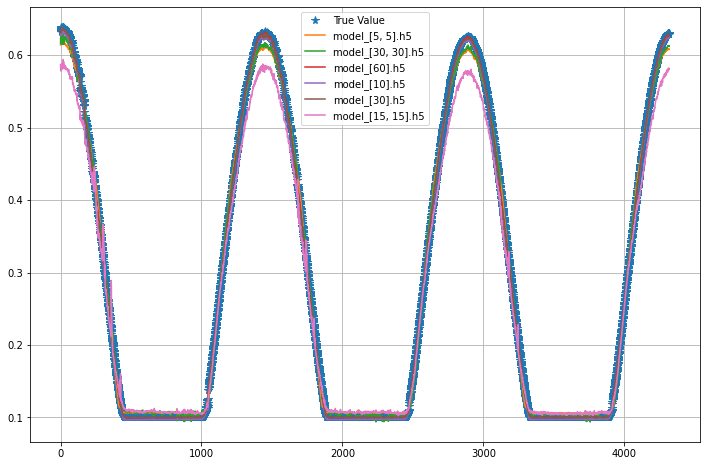

In [ ]:
make_graph_plt(X_test,y_test,3)


In [ ]:
make_graph_ly(X_test[0:1440*3], y_test[0:1440*3])

In [ ]:
#@title Zip
!zip -r /content/tmp_com_ghi.zip /content/tmp_com_ghi
from google.colab import files
files.download("/content/tmp_com_ghi.zip")

  adding: content/tmp_com_ghi/ (stored 0%)
  adding: content/tmp_com_ghi/relu_1/ (stored 0%)
  adding: content/tmp_com_ghi/relu_1/model_[5, 5].h5 (deflated 90%)
  adding: content/tmp_com_ghi/relu_1/model_[30, 30].h5 (deflated 70%)
  adding: content/tmp_com_ghi/relu_1/model_[60].h5 (deflated 73%)
  adding: content/tmp_com_ghi/relu_1/model_[10].h5 (deflated 88%)
  adding: content/tmp_com_ghi/relu_1/model_[30].h5 (deflated 81%)
  adding: content/tmp_com_ghi/relu_1/model_[15, 15].h5 (deflated 83%)
  adding: content/tmp_com_ghi/relu_60/ (stored 0%)
  adding: content/tmp_com_ghi/relu_60/model_[5, 5].h5 (deflated 90%)
  adding: content/tmp_com_ghi/relu_60/model_[30, 30].h5 (deflated 70%)
  adding: content/tmp_com_ghi/relu_60/model_[60].h5 (deflated 75%)
  adding: content/tmp_com_ghi/relu_60/model_[10].h5 (deflated 88%)
  adding: content/tmp_com_ghi/relu_60/model_[30].h5 (deflated 82%)
  adding: content/tmp_com_ghi/relu_60/model_[15, 15].h5 (deflated 83%)
  adding: content/tmp_com_ghi/relu_30/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Teste

In [ ]:
#!unzip "/content/drive/My Drive/UNILA/Pesquisa/2020/IC Victor/2020-2021/Artigo 1 RBIC/Artigo 1_resultados.zip"

Archive:  /content/drive/My Drive/UNILA/Pesquisa/2020/IC Victor/2020-2021/Artigo 1 RBIC/Artigo 1_resultados.zip
   creating: Artigo 1/Variaveis ampliadas/
   creating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/
   creating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_1/
  inflating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_1/model_[10].h5  
  inflating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_1/model_[15, 15].h5  
  inflating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_1/model_[30, 30].h5  
  inflating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_1/model_[30].h5  
  inflating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_1/model_[5, 5].h5  
  inflating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_1/model_[60].h5  
   creating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_30/
  inflating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_30/model_[10].h5  
  inflating: Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_30/model_[15, 15].h5  
  inflating: Artigo 1/Variaveis a

In [ ]:
def get_result(path, X, y):

  path = glob(path+"/*")
  indexs = [i.split("/")[-1] for i in path]
  data = {}
  for i in indexs:
    data[i] = None
  
  for i in path:

    name = i.split("/")[-1]

    clear_session()
    model = load_model(i,custom_objects={'coeff_determination':coeff_determination})
    loss = model.evaluate(X,y, verbose=0)
    data[name] = loss
    y_pred = model.predict(X)
    r2 = r2_score(y,y_pred)
    data[name][-1] = r2
    
  data = pd.DataFrame.from_dict(data,orient="index",columns=["MSE","RMSE","MAPE(%)","R2"])

  return data

1 minuto com ghi, 30 minuto com ghi, 60 minuto com ghi, 1 minuto sem ghi ( variavel ampliada)

60 minuto sem ghi(variavel reduzida)

In [ ]:
#@title Caminhos
weatherPath = "/content/drive/My Drive/IC Victor/2019-2020/Projeto EUA/Folsom_weather.csv" #@param {type:"string"}
irradiancePath = "/content/drive/My Drive/IC Victor/2019-2020/Projeto EUA/Folsom_irradiance.csv" #@param {type:"string"}
drops =  None#@param {type:"raw"}
horizonte =   60#@param {type:"number"}
data = get_data(weatherPath, 
                irradiancePath,
                horizonte,
                drops)


train = data[data.index.year != 2016]
test = data[data.index.year == 2016]

trainNorm = 0.1 + 0.8 * ((train - train.min()) / (train.max() - train.min()))
testNorm = 0.1 + 0.8 * ((test - test.min()) / (test.max() - test.min()))

TrainDataset = np.hstack([trainNorm[i].values.reshape((len(trainNorm[i]),1)) for i in trainNorm.columns])
TestDataset = np.hstack([testNorm[i].values.reshape((len(testNorm[i]),1)) for i in testNorm.columns])

ghi = False #@param {type:"boolean"}

if ghi:
  #Treino
  X_train, y_train = split_sequences_ghi(TrainDataset, 1)

  #Validação
  X_val, y_val =  split_sequences_ghi(TestDataset[:int(len(TestDataset)/2)], 1)

  #test
  X_test, y_test = split_sequences_ghi(TestDataset[int(len(TestDataset)/2):], 1)

else: 
  #Treino
  X_train, y_train = split_sequences(TrainDataset, 1)

  #Validação
  X_val, y_val =  split_sequences(TestDataset[:int(len(TestDataset)/2)], 1)

  #test
  X_test, y_test = split_sequences(TestDataset[int(len(TestDataset)/2):], 1)


n_in = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape((X_train.shape[0], n_in))

X_val = X_val.reshape((X_val.shape[0], n_in))

X_test = X_test.reshape((X_test.shape[0], n_in))

In [ ]:
path = "/content/Artigo 1/Variaveis ampliadas/tmp_com_ghi/relu_1"

In [ ]:
result = get_result(path,X_test,y_test)

In [ ]:
result

,MSE,RMSE,MAPE(%),R2
"model_[5, 5].h5",0.008068,0.089820,28.924074,0.804740
"model_[30, 30].h5",0.002164,0.046523,13.133954,0.947615
model_[60].h5,0.003097,0.055647,16.412271,0.925054
model_[10].h5,0.008324,0.091237,38.973495,0.798531
model_[30].h5,0.006137,0.078342,26.780888,0.851456
"model_[15, 15].h5",0.004622,0.067984,22.972713,0.888139
